<br>

## 3. Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import rc
import missingno as msno

In [2]:
rc('font', family='Malgun Gothic') # Windows OS 
# rc('font', family='AppleGothic') # os x(mac os)  

%matplotlib inline
plt.style.use("ggplot") # 그래프를 격자 스타일로 (숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용.)
mpl.rcParams["axes.unicode_minus"] = False # 그래프에서 마이너스 폰트 깨지는 문제 해결을 위해

In [3]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# null이 있는 데이터 미리 체크
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:>

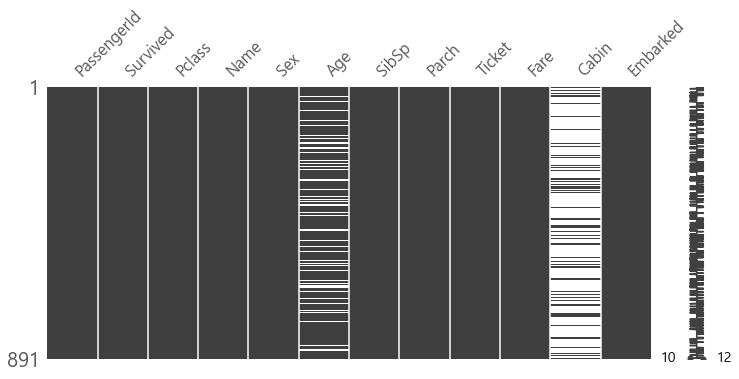

In [5]:
msno.matrix(titanic_df, figsize=(12,5))

## Cabin, Ticket (Delete)

In [6]:
del titanic_df['Cabin'] # 너무 많은 결측치가 존재
del titanic_df['PassengerId'] # Passenger 번호는 큰 의미를 갖고있지 않은 일련번호
del titanic_df['Ticket'] # ticket 번호에서 패턴이 확인되지 않음

## Name (to Title-only)

In [7]:
titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
titanic_df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Sir           1
Ms            1
Jonkheer      1
Mme           1
Don           1
Countess      1
Capt          1
Lady          1
Name: Title, dtype: int64

In [8]:
set(titanic_df['Title'])

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [9]:
rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

titanic_df[['Title','Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [10]:
del titanic_df['Name'] # 호칭만 남김

In [11]:
# Str(Category/Factor) -> Int

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }

titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)

titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,3
1,1,1,female,38.0,1,0,71.2833,C,4
2,1,3,female,26.0,0,0,7.9250,S,2


## Sex (Text to Number)

In [12]:
# (추후 변경해서 다시 진행해보기) Female 이 생존 비율이 훨씬 높으므로 2.5 정도로 가중치를 줄 경우 accuracy가 향상됩니다.
sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)

titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,3
1,1,1,1,38.0,1,0,71.2833,C,4
2,1,3,1,26.0,0,0,7.9250,S,2


## Embarked (Fill-in missing values, Text to Number)

<AxesSubplot:>

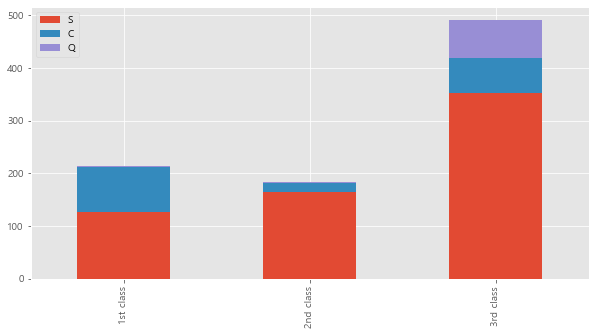

In [13]:
Pclass1 = titanic_df[titanic_df['Pclass']==1]['Embarked'].value_counts()
Pclass2 = titanic_df[titanic_df['Pclass']==2]['Embarked'].value_counts()
Pclass3 = titanic_df[titanic_df['Pclass']==3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']

df.plot(kind='bar',stacked=True, figsize=(10,5))

In [14]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Title     891 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 62.8+ KB


In [15]:
# 결측치가 2개 뿐이므로 class 마다 가장 많은 비율을 갖고 있는 S 로 채워넣는다.

titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,3
1,1,1,1,38.0,1,0,71.2833,C,4
2,1,3,1,26.0,0,0,7.9250,S,2


In [16]:
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,0,3
1,1,1,1,38.0,1,0,71.2833,2,4
2,1,3,1,26.0,0,0,7.9250,0,2


## Fare (Categorizing)

In [17]:
titanic_df["Fareband"] = pd.cut(titanic_df["Fare"], 5) # Bin values into discrete intervals.
titanic_df[['Fareband','Survived']].groupby('Fareband').mean().sort_values(by='Survived', ascending=False)

,Survived
Fareband,
"(409.863, 512.329]",1.000000
"(102.466, 204.932]",0.757576
"(204.932, 307.398]",0.647059
"(-0.512, 102.466]",0.361575
"(307.398, 409.863]",NaN


In [20]:
del titanic_df['Fareband']

titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4

titanic_df['Fare'].value_counts()

0.0    838
1.0     33
2.0     17
4.0      3
Name: Fare, dtype: int64

## Parch & Sibsp (가구 단위로 합치고 Categorizing, 단독가구를 새로운 feature로 생성)

In [21]:
# parch, sibsp의 경우 0 or 1이 많음, family 전체 사이즈로 합쳐보기 (본인 포함 탑승한 가족 구성원 수)

titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
titanic_df[['FamilySize','Survived']].groupby('FamilySize', as_index=False).mean().sort_values(by='Survived',ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [22]:
# 가족 구성원이 1인 경우 survived 비율이 30% 인데 537 가구로 전체에서 많은 비중을 차지함 
titanic_df["FamilySize"].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [23]:
# 1인 가구인 경우는 1, 아닌 경우는 0으로 'isAlone' column을 추가

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,22.0,1,0,0.0,0,3,2,0
1,1,1,1,38.0,1,0,0.0,2,4,2,0
2,1,3,1,26.0,0,0,0.0,0,2,1,1


In [24]:
# 기존의 sibsp & parch 열을 지우고, Fare 의 구간과 유사하게 0~4로 구간화

del titanic_df['SibSp']
del titanic_df['Parch']

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)
titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,22.0,0.0,0,3,0.4,0
1,1,1,1,38.0,0.0,2,4,0.4,0
2,1,3,1,26.0,0.0,0,2,0.0,1


## Age

In [25]:
# 중위값으로 결측치를 채워넣음

titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)
titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,22.0,0.0,0,3,0.4,0
1,1,1,1,38.0,0.0,2,4,0.4,0
2,1,3,1,26.0,0.0,0,2,0.0,1


In [114]:
## 결측치를 별도의 머신러닝 모델을 만들어 채워넣을 수도 있음

# from sklearn.ensemble import RandomForestRegressor

# titanic_df["Age"].fillna(0, inplace=True)
# f_columns = ['Pclass', 'Sex', 'Fare', 'Embarked', 'Title', 'FamilySize']
# AgeNull = titanic_df[titanic_df['Age']==0]
# AgeNotNull = titanic_df[titanic_df['Age']!=0]
# X_train = AgeNotNull[f_columns]

# random_forest = RandomForestRegressor(n_estimators=200)
# random_forest.fit(X_train, AgeNotNull["Age"]) # 나이 정보가 있는 열로 나이 열을 맞추기 위한 모델을 학습

# train_pred = random_forest.predict(AgeNull[f_columns])
# AgeNull["Age"]= train_pred

# titanic_df = AgeNotNull.append(AgeNull)

In [26]:
# Categorizing

titanic_df['AgeBand'] = pd.cut(titanic_df['Age'], 5)
titanic_df[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.548077
1,"(16.336, 32.252]",0.327345
2,"(32.252, 48.168]",0.439024
3,"(48.168, 64.084]",0.428571
4,"(64.084, 80.0]",0.090909


In [27]:
del titanic_df['AgeBand']

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


<br>

## 4. Devide dataframe into X & Y 

In [28]:
titanic_target = titanic_df['Survived'].copy()
titanic_data = titanic_df.copy()
del titanic_data['Survived']

<br>

## 5. Modeling

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

#### Train_test_split 대신 Cross Validation ( K-fold) 사용 가능
KFold 객체를 만든 후, cross_val_score 함수에게 모델 객체와 KFold 객체를 데이터와 함께 넘겨주면 자동으로 계산해줍니다.

In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
scoring ='accuracy'

## 5-1. Logistic regression

In [31]:
clf = LogisticRegression(solver='lbfgs')

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.81111111 0.78651685 0.7752809  0.79775281 0.76404494 0.78651685
 0.76404494 0.85393258 0.80898876 0.79775281]
79.46


## 5-2. KNN

In [32]:
clf = KNeighborsClassifier(n_neighbors=13)

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.77777778 0.78651685 0.80898876 0.80898876 0.84269663 0.80898876
 0.82022472 0.82022472 0.78651685 0.7752809 ]
80.36


## 5-3. Navie Bayes

In [33]:
clf = GaussianNB()

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.82222222 0.7752809  0.79775281 0.82022472 0.80898876 0.80898876
 0.82022472 0.85393258 0.80898876 0.84269663]
81.59


## 5-4. Decision Tree

In [34]:
clf = DecisionTreeClassifier()

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.82222222 0.82022472 0.79775281 0.82022472 0.84269663 0.78651685
 0.82022472 0.79775281 0.79775281 0.78651685]
80.92


## 5-5. Randomforest

In [35]:
clf = RandomForestClassifier(n_estimators=200)

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.82222222 0.79775281 0.79775281 0.80898876 0.83146067 0.75280899
 0.83146067 0.79775281 0.79775281 0.79775281]
80.36


## 5-6. GradientBoosting

In [36]:
clf = GradientBoostingClassifier(n_estimators=200)

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.83333333 0.82022472 0.79775281 0.80898876 0.84269663 0.79775281
 0.82022472 0.82022472 0.79775281 0.83146067]
81.7


## 5-7. SVM

In [37]:
clf = SVC(gamma='auto')

score = cross_val_score(clf, titanic_data, titanic_target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.85555556 0.80898876 0.80898876 0.82022472 0.85393258 0.83146067
 0.83146067 0.86516854 0.83146067 0.86516854]
83.72


## For further improvements,

- Try hyperparams tuning with GridSearchCV
- Check other metrics like AUC